In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import deepcopy
import subprocess
import rasterio
from rasterio.plot import show
import geopandas as gpd
from funcs import *
from scipy.ndimage import zoom
from sklearn.metrics import mean_squared_error
from rasterio import mask as msk
import pandas as pd
import scipy.io
from model import *

In [2]:
with open('./auto_data/Kronebreen_auto_1420_it_parameters.p_friction_1000_it_fields.vel_mes_it_parameters.pmax_4997__0.pkl', 'rb') as inp:
    md = pickle.load(inp)

In [40]:
print(md.warnings)

[]


Text(0.5, 1.0, 'Bed deviation compared to initial bed vs iter')

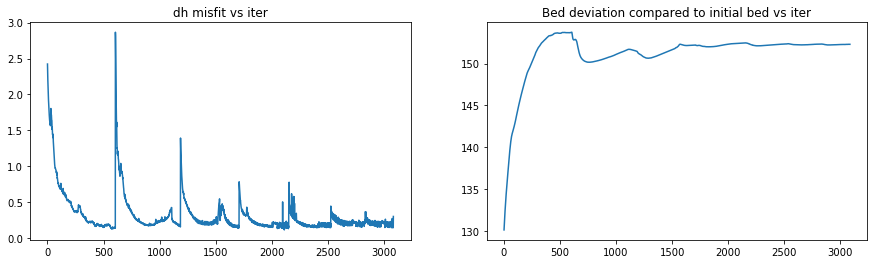

In [3]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
line = ax[0].plot(md.series.dh_misfit_vs_iter)
line = ax[1].plot(abs(np.array(md.series.B_misfit_vs_iter)))
ax[0].set_title('dh misfit vs iter')
ax[1].set_title('Bed deviation compared to initial bed vs iter')
#ax[0].set_ylim([0,5])

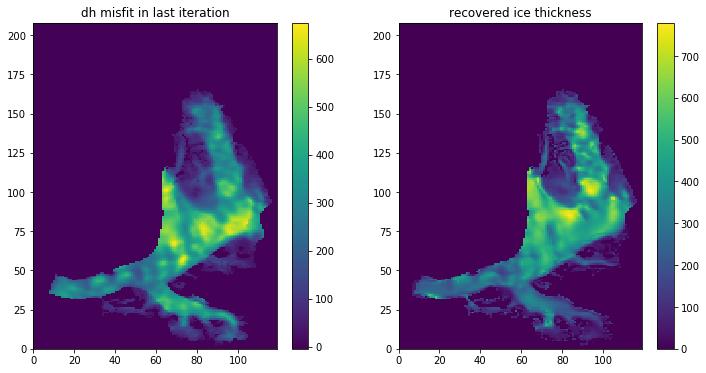

In [12]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
field = ax[0].pcolor(md.it_fields.mask*data.thk_Millan)#, vmin = -1, vmax = 1, cmap='RdBu')
field1 = ax[1].pcolor(md.it_fields.S_ref-md.series.B_rec_all[-1])
ax[0].set_title('dh misfit in last iteration')
ax[1].set_title('recovered ice thickness')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

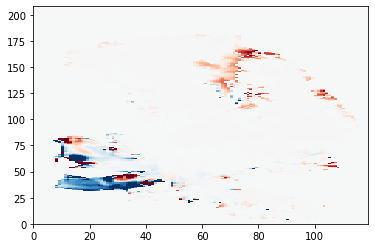

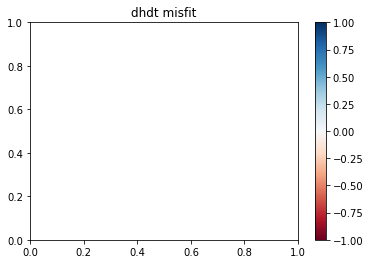

In [42]:
from IPython.display import display, clear_output #needed for animated plots

fig, axes = plt.subplots()
for i in range(0,len(md.series.B_rec_all),50):
    field = axes.pcolor(md.series.misfit_all[i], cmap='RdBu', vmin=-1, vmax=1)
    #field = axes.pcolor(md.series.S_rec_all[i]-md.series.B_rec_all[i], vmax=800, vmin=0)
    clear_output(wait=True)
    display(fig)
    axes.cla()
axes.set_title('dhdt misfit')
fig.colorbar(field)

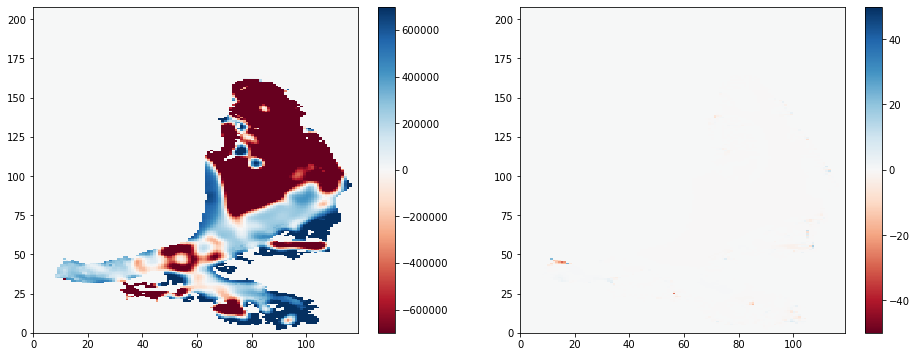

In [7]:
nc_field = 'velsurf_mag'
fig, ax = plt.subplots(1,2,figsize = (16,6))
field = ax[0].pcolor((md.series.tauc_recs[0]-md.series.tauc_recs[-1])*data.mask_Kr, vmin = -7e5, vmax = 7e5, cmap='RdBu')
#field1 = ax[1].pcolor((md.it_products.vel_mismatch)*data.mask_Kr, cmap='RdBu', vmin = -.5, vmax=.5)
field1 = ax[1].pcolor((md.series.B_rec_all[-1] - md.series.B_rec_all[-350])*data.mask_Kr,cmap='RdBu', vmin = -50, vmax=50)
#field1 = ax[1].pcolor((bla)*np.minimum(md.it_fields.vel_mes,1)*md.it_fields.mask, cmap='RdBu', vmin = -.5, vmax=.5)
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

/home/thomas/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


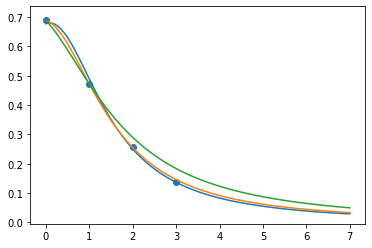

In [14]:
poly1 = np.poly1d(np.polyfit(range(4),1/np.array(mis_ser)[range(1001,4002,1000)],2))
poly2 = np.poly1d(np.polyfit(range(3),1/np.array(mis_ser)[range(1001,3002,1000)],2))
poly3 = np.poly1d(np.polyfit(range(2),1/np.array(mis_ser)[range(1001,2002,1000)],2))
fit1 = poly1(np.linspace(0,7,100))
fit2 = poly2(np.linspace(0,7,100))
fit3 = poly3(np.linspace(0,7,100))
plt.scatter(range(4),np.array(mis_ser)[range(1001,4002,1000)])
plt.plot(np.linspace(0,7,100), 1/fit1)
plt.plot(np.linspace(0,7,100), 1/fit2)
plt.plot(np.linspace(0,7,100), 1/fit3)

(-0.1, 1.5)

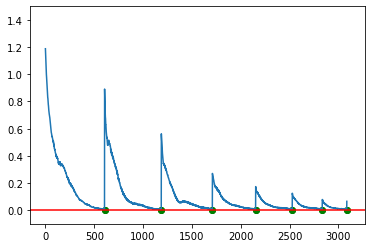

In [8]:
vel_ser = []
mis_ser = []
stop = []
for i in range(len(md.series.B_rec_all)):
    #vel_ser.append(np.median(((md.series.vel_all[i]-md.it_fields.vel_mes)/md.it_fields.vel_mes)[np.logical_and(data.mask_Kr==1, data.x<455000)]))
    mis_ser.append(np.median(abs(md.series.misfit_all[i][data.mask_Kr==1])))
    if i > 20 and np.all(abs(np.array(mis_ser[-20:-1])) < 1e-2):
        stop.append(i)
fig,ax = plt.subplots()
line = ax.plot(mis_ser)
plt.scatter(stop, [0]*len(stop), c='g')
ax.axhline(0, c='r')
ax.set_ylim([-.1,1.5])

In [67]:
        DEM_VEL_mat = scipy.io.loadmat('./kronebreen/HDF_2021_10_06.mat')['HDF'][0,0]


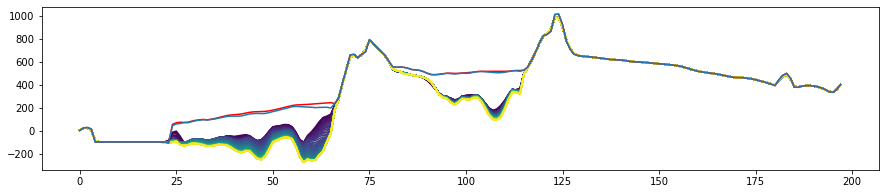

In [26]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(md.series.B_rec_all))]
fig, ax = plt.subplots(figsize=(15,3))
for i in range(0,len(md.series.B_rec_all),1):
    lines = ax.plot(gauss_filter(md.series.B_rec_all[i],.5,3)[60,:], color = colors[i])
lines = ax.plot((md.series.S_rec_all[-1])[60,:], color = 'r')
#line = ax.plot(((md.it_products.h_rec+md.it_fields.B_rec)*md.it_fields.mask)[40,:], 'b')
line = ax.plot((md.it_fields.S_ref)[60,:])

In [6]:
#data = input_data()
#data.build_input()

radar = radar_data()
radar.rad_as_array(data)

Text(0.5, 1.0, 'measured vs calculated bed elevation')

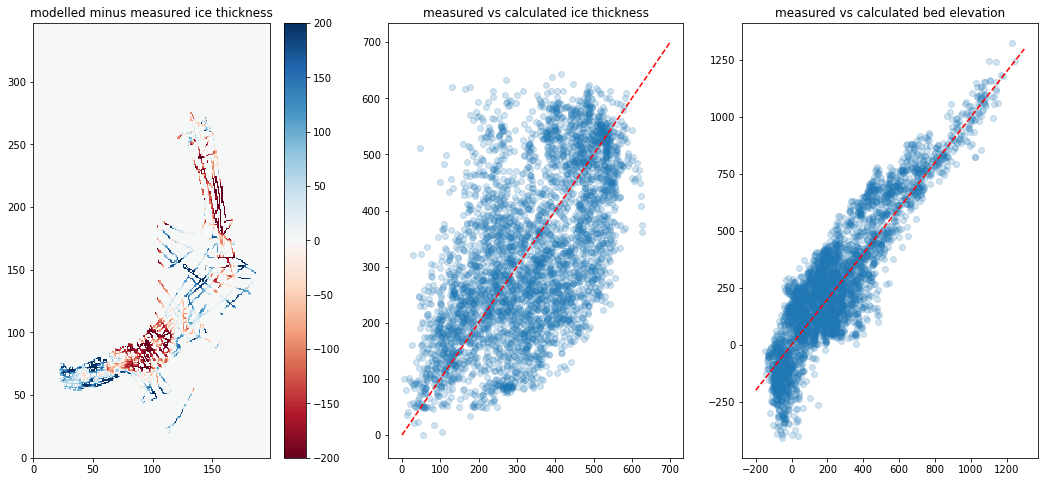

In [27]:
it_step = -1
fig, ax = plt.subplots(1,3, figsize=(18,8))
field = ax[0].pcolor((((md.series.S_rec_all[it_step]-md.series.B_rec_all[it_step])-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask), vmax = 200, vmin = -200, cmap='RdBu')
#field = ax[0].pcolor(((test)-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask, vmax = 200, vmin = -200, cmap='RdBu')
fig.colorbar(field, ax = ax[0])

line = ax[1].plot(range(700), range(700), '--', c='r')
scatter = ax[1].scatter((md.it_fields.S_ref-radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], (md.series.S_rec_all[it_step]-md.series.B_rec_all[it_step])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2)
##scatter = ax[1].scatter((md.it_fields.S_ref-radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], test[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2, c='r')

scatter = ax[2].scatter(radar.bed_arr[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], (md.series.B_rec_all[it_step])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2)
line = ax[2].plot(range(-200, 1300), range(-200, 1300), '--', c='r')

ax[0].set_title('modelled minus measured ice thickness')
ax[1].set_title('measured vs calculated ice thickness')
ax[2].set_title('measured vs calculated bed elevation')
#plt.savefig('mod_minus_mes_thickness.png', res=400)

In [32]:
test = md.series.S_rec_all[it_step] - md.series.B_rec_all[it_step]
test[md.it_fields.mask==0]=np.nan
test = gauss_filter(test,.6,3)
test[md.it_fields.mask==0]=0

/home/thomas/pism-stable/thick_inv/model.py:534: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


In [28]:
import scipy.stats as st
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
thick_ref_at_rad = (md.it_fields.S_ref - radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
thick_rec_at_rad = (md.series.S_rec_all[it_step] - md.series.B_rec_all[it_step])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
#thick_rec_at_rad = test[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
dev = (thick_rec_at_rad - thick_ref_at_rad)/280
mean_dev = np.nanmean((dev))
mean_abs_dev = np.nanmean(abs(thick_rec_at_rad - thick_ref_at_rad))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
#conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
conf_dev = (np.nanpercentile(dev, 5), np.nanpercentile(dev, 95))
RMSE = math.sqrt(mean_squared_error(thick_ref_at_rad, thick_rec_at_rad))
print('RMSE: {} m'.format(RMSE))
print('mean deviation: {} %'.format(mean_dev))
print('mean absolute deviation: {} m'.format(mean_abs_dev))
print('median deviation: {} %'.format(med_dev))
print('Interquartile range of deviation: {}%'.format(IQR_dev))
print('95% confidence intervall: {}%'.format(conf_dev))

RMSE: 129.86716270692088 m
mean deviation: -0.03196566318243685 %
mean absolute deviation: 104.56992214179627 m
median deviation: -0.016472702921441446 %
Interquartile range of deviation: 0.644484501278062%
95% confidence intervall: (-0.7644240222980664, 0.7266181277959984)%


In [30]:
dev_all = []
mean_dev_all = []
mean_abs_dev_all = []
med_dev_all = []
IQR_dev_all = []
conf_dev_all = []
RMSE_all = []
thick_ref = (md.it_fields.S_ref - radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
for i in range(len(md.series.B_rec_all)):
    thick_rec = (md.it_fields.S_ref - md.series.B_rec_all[i].data)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
    dev_all.append((thick_rec - thick_ref)/280)
    mean_dev_all.append(np.nanmean((dev_all)))
    mean_abs_dev_all.append(np.nanmean(abs(thick_rec - thick_ref)))
    med_dev_all.append(np.nanmedian(dev_all[i]))
    IQR_dev_all.append(np.nanpercentile(dev_all[i], 75) - np.nanpercentile(dev_all[i], 25))
    conf_dev_all.append(np.nanpercentile(dev_all[i], 95) - np.nanpercentile(dev_all[i], 5))
    RMSE_all.append(math.sqrt(mean_squared_error(thick_ref, thick_rec)))

Text(0.5, 1.0, 'RMSE of deviation')

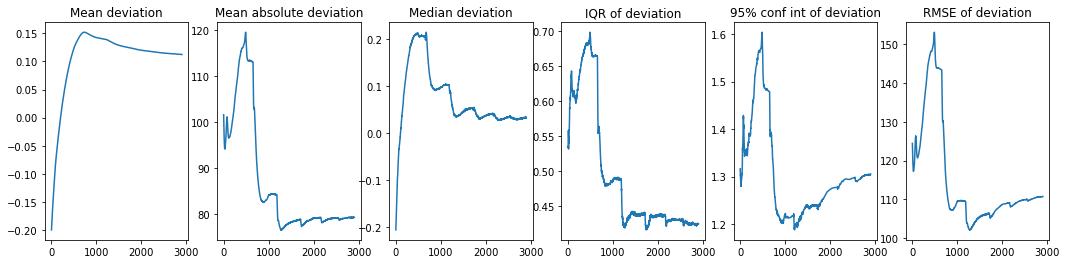

In [31]:
fig, ax = plt.subplots(1,6, figsize=(18,4))
line1 = ax[0].plot(mean_dev_all)
line2 = ax[1].plot(mean_abs_dev_all)
line3 = ax[2].plot(med_dev_all)
line4 = ax[3].plot(IQR_dev_all)
line5 = ax[4].plot(conf_dev_all)
line6 = ax[5].plot(RMSE_all)
ax[0].set_title('Mean deviation')
ax[1].set_title('Mean absolute deviation')
ax[2].set_title('Median deviation')
ax[3].set_title('IQR of deviation')
ax[4].set_title('95% conf int of deviation')
ax[5].set_title('RMSE of deviation')

Text(0.5, 1.0, 'percent deviation relative to stake velocities between stake and ITS_LIVE velocities')

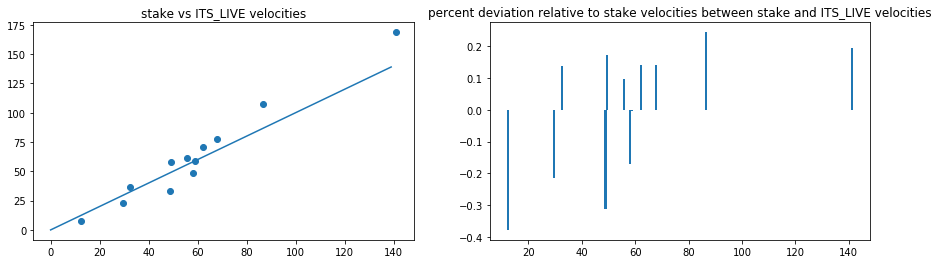

In [109]:
### velocity from Jack ###
vel_xyz_df = pd.read_excel('./kronebreen/HDF_stake_velocities.xlsx', 1, header=None)
vel_x = np.array(vel_xyz_df.loc[:,1])
vel_y = np.array(vel_xyz_df.loc[:,2])
vel_z = np.array(vel_xyz_df.loc[:,3])

vel_df = pd.read_excel('./kronebreen/HDF_stake_velocities.xlsx', 0, header=None)
vel_1420 = np.nanmean(np.array(vel_df.loc[3:,range(20,30,2)]), axis=1)
vel_mes_at_stakes = get_nearest(data.x,data.y,(data.vel_Jack/365/3.8)*(365/24)*100, vel_x, vel_y)
fig,ax = plt.subplots(1,2, figsize = (15,4))
points = ax[0].scatter(vel_1420, vel_mes_at_stakes)
line = ax[0].plot(range(140), range(140))
points1 = ax[1].bar(vel_1420, (vel_mes_at_stakes  - vel_1420)/vel_1420)

ax[0].set_title('stake vs ITS_LIVE velocities')
ax[1].set_title('percent deviation relative to stake velocities between stake and ITS_LIVE velocities')

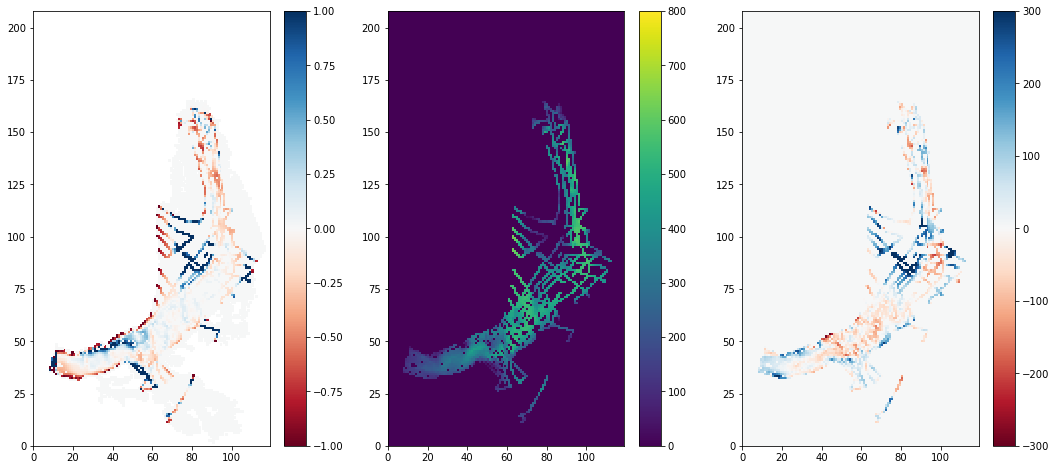

In [15]:
fig,ax = plt.subplots(1,3,figsize = (18,8))
field = ax[0].pcolor((md.series.vel_all[it_step]-data.vel_Millan)/(data.vel_Millan)*radar.mask_arr*np.minimum(md.it_fields.vel_mes,1), cmap = 'RdBu', vmin = -1, vmax = 1)
field1 = ax[1].pcolor((md.it_fields.S_ref - radar.bed_arr)*radar.mask_arr*md.it_fields.mask, vmax = 800, vmin = 0)
field2 = ax[2].pcolor(((md.it_fields.S_rec - md.it_fields.B_rec)-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask, vmax = 300, vmin = -300, cmap='RdBu')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])
fig.colorbar(field2, ax = ax[2])

In [39]:
np.max(data.vel_Jack[data.mask==1])

1192.331434083252

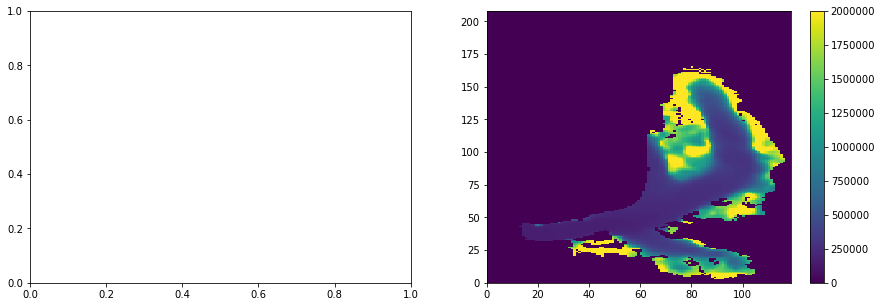

In [67]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#field = ax[0].pcolor(md.it_fields.tauc_rec*data.mask, vmin = 0, vmax=2e6)#, cmap='RdBu')
field1= ax[1].pcolor((1/data.vel_Jack+.02)*8e6*data.mask, vmin = 0, vmax = 2e6)
#fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

In [7]:
        nc_updated = NC(md.file_locations.it_in, 'r+')
        nc_updated['topg'][0,:,:] = md.it_fields.B_rec
        nc_updated['thk'][0,:,:]=md.it_products.h_old
        nc_updated['tauc'][0,:,:]= md.it_fields.tauc_rec
        nc_updated['climatic_mass_balance'][0,:,:] = md.it_fields.smb
        nc_updated.close()

In [21]:
data = input_data()
data.build_input()
md = model(data)
md.it_parameters.pmax=100
md.it_parameters.smooth_surf_in=(0,0)
md.it_parameters.dt = 0.03
md.it_parameters.delta_surf = 0.05
md.it_parameters.A = 8e-24
md.it_fields.tauc_rec[data.mask==1] = (1/data.vel_Jack[data.mask==1]+.02)*2e7
md.iterate(data)
#md.it_fields.S_rec = copy(md.it_fields.S_ref)
#md.restart(-1)

/home/thomas/pism-stable/thick_inv/model.py:535: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


NetCDF file  kronebreen_kongsbreen_initialSetup.nc  created


# =======================================================================
# initialize Kronebreen
#  4 processors, 1 a run, 50 km grid, kronebreen_kongsbreen_initialSetup.nc, kronebreen_kongsbreen_output.nc > kronebreen_kongsbreen_output_log.txt
# =======================================================================

Reading configuration parameters (pism_overrides) from file 'kronebreen_kongsbreen_conf.nc'.
Reading configuration parameters (pism_config) from file '/home/thomas/pism/share/pism/pism_config.nc'.
PISMR (basic evolution run mode) stable v1.2.2 committed by Constantine Khrulev on 2020-08-28 12:22:53 -0800
  setting computational box for ice from 'kronebreen_kongsbreen_initialSetup.nc' and
    user options: [-14.93 km,  14.93 km] x [-26.10 km,  26.10 km] x [0 m, 1500.00 m]
* Run time: [0.000, 1.000]  (1.000 years, using the '365_day' calendar)
# Allocating the geometry evolution model...
# Allocating an iceberg 

/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


1


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


2


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


3


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


4


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


5


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


6


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


7


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


8


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


9


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


10


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


11


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


12


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


13


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


14


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


15


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


16


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


17


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


18


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


19


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


20


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


21


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


22


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


23


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


24


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


25


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


26


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


27


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


28


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


29


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


30


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


31


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


32


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


33


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


34


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


35


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


36


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


37


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


38


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


39


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


40


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


41


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


42


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


43


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


44


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


45


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


46


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


47


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


48


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


49


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


50


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


51


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


52


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


53


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


54


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


55


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


56


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


57


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


58


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


59


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


60


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


61


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


62


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


63


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


64


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


65


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


66


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


67


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


68


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


69


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


70


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


71


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


72


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


73


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


74


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


75


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


76


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


77


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


78


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


79


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


80


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


81


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


82


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


83


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


84


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


85


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


86


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


87


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


88


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


89


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


90


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


91


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


92


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


93


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


94


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


95


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


96


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


97


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


98


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


99


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


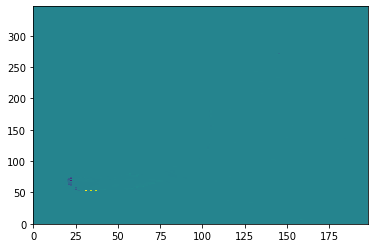

In [3]:
plt.pcolor(md.it_products.dh_rec)

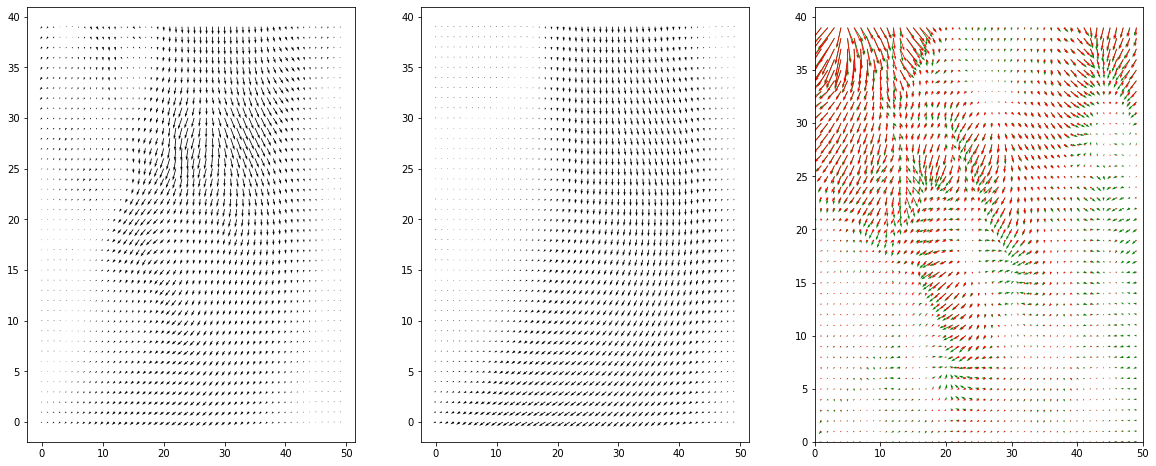

In [24]:
fig, ax = plt.subplots(1,3,figsize=(20,8))
#field1 = ax[0].pcolor((md.series.tauc_recs[0])[130:170,130:180], vmin = 0, vmax = 5e6)#, cmap='RdBu')
field = ax[0].quiver((md.it_products.u_mod*md.it_fields.mask)[130:170,130:180], (md.it_products.v_mod*md.it_fields.mask)[130:170,130:180], scale=1e3)
#field2 = ax[2].pcolor((((md.series.S_rec_all[it_step]-md.series.B_rec_all[it_step])-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask*np.minimum(1, md.it_products.vel_mod))[75:110,60:110], vmax = 200, vmin = -200, cmap='RdBu')
#field2 = ax[2].pcolor((md.it_fields.S_ref - md.it_fields.S_rec)[75:110,60:110], vmin = -50, vmax = 50, cmap='RdBu')
field1 = ax[1].quiver(data.vx_Jack[130:170,130:180], data.vy_Jack[130:170,130:180])#, scale=8e-1)
field3 = ax[2].pcolor((md.it_fields.S_rec - md.it_fields.S_ref)[7130:170,130:180], vmin = -20, vmax = 20, cmap='RdBu')
#field3 = ax[2].pcolor((md.it_products.misfit)[75:110,70:110], vmin = -1, vmax = 1, cmap='RdBu')
field2 = ax[2].quiver(x_deriv(stagger(md.it_fields.S_ref*md.it_fields.mask),250)[130:170,130:180], y_deriv(stagger(md.it_fields.S_ref*md.it_fields.mask),250)[130:170,130:180], scale=.1e1, color='g')
field2 = ax[2].quiver(x_deriv(stagger(md.it_fields.S_rec*md.it_fields.mask),250)[130:170,130:180], y_deriv(stagger(md.it_fields.S_rec*md.it_fields.mask),250)[130:170,130:180], scale=.1e1, color='r')

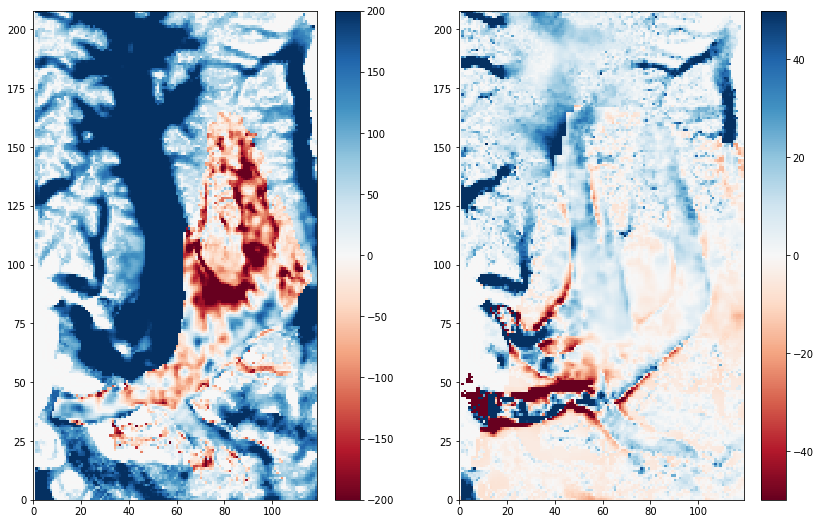

In [61]:
fig,ax = plt.subplots(1,2, figsize = (14,9))
field = ax[0].pcolor(thk - (md.it_fields.S_rec-md.it_fields.B_rec)*md.it_fields.mask, vmax =-200, vmin = 200, cmap='RdBu')
field1 = ax[1].pcolor(vel - data.vel_Jack, vmax =-50, vmin = 50, cmap='RdBu')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

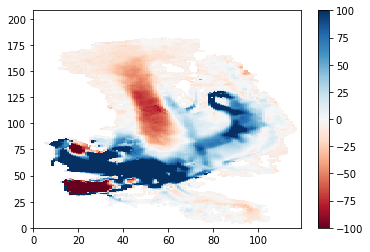

In [8]:
fig, ax = plt.subplots()
#field = ax.pcolor(get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'velsurf_mag',0),vmax=1000)
field = ax.pcolor(md.it_products.vel_mod-data.vel_Adrian, cmap = 'RdBu', vmin = -100, vmax = 100)
fig.colorbar(field, ax = ax)

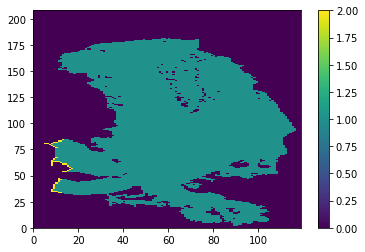

In [4]:
fig,ax = plt.subplots()
field = ax.pcolor(data.mask+data.contact_zone)#, vmin = 0, vmax = 90)
fig.colorbar(field, ax = ax)

In [26]:
data1 = input_data()
DEM_VEL_mat = scipy.io.loadmat('./kronebreen/HDF_2021_10_06.mat')['HDF'][0,0]
data1.set_xy(DEM_VEL_mat)
data1.reset_shape()
data1.import_NPI_DEM("./kronebreen/S0_DTM50.tif")
data1.get_vel(DEM_VEL_mat)
data1.get_outlines('./kronebreen/rgi_outlines/07_rgi60_Svalbard.shp')
data1.get_dhdt(DEM_VEL_mat)
data1.get_mask()
#data1.clean_dhdt()
data1.get_vel_Adrian()
#data1.resample_input()

In [27]:
with rasterio.open('./kronebreen/S0_DTM50.tif') as src:
    profile = src.profile.copy()
    profile1 = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a  * 5, aff.b, aff.c+data.window.col_off*50,
                             aff.d, aff.e * 5, aff.f-data.window.row_off*50)

    newaff1 = rasterio.Affine(aff.a, aff.b, aff.c+data.window.col_off*50,
                             aff.d, aff.e, aff.f-data.window.row_off*50)
    profile.update({
            'dtype': 'float32',
            'height':md.it_fields.B_rec.shape[0],
            'width':md.it_fields.B_rec.shape[1],
            'transform': newaff}) 
    profile1.update({
            'dtype': 'float32',
            'height':data1.mask.shape[0],
            'width':data1.mask.shape[1],
            'transform': newaff1}) 
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/B_rec.tif', 'w', **profile) as dst:
    dst.write_band(1, np.flip(md.it_fields.B_rec, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/dhdt.tif', 'w', **profile) as dst:
    dhdt_mask = np.zeros_like(md.it_fields.S_ref)*np.nan
    dhdt_mask[data.mask_Kr==1] = data.dhdt[data.mask_Kr==1]
    dst.write_band(1, np.flip(dhdt_mask, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/data.mask_Kr.tif', 'w', **profile) as dst:
    dst.write_band(1, np.flip(data.mask_Kr, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/smb.tif', 'w', **profile) as dst:
    smb_mask = np.zeros_like(md.it_fields.S_ref)*np.nan
    smb_mask[data.mask_Kr==1] = md.it_fields.smb[data.mask_Kr==1]
    dst.write_band(1, np.flip(smb_mask, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/thick.tif', 'w', **profile) as dst:
    thick = np.zeros_like(md.it_fields.S_ref)*np.nan
    thick[data.mask_Kr==1] = md.it_fields.S_rec[data.mask_Kr==1] -md.it_fields.B_rec[data.mask_Kr==1]
    dst.write_band(1, np.flip(thick, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Adrian.tif', 'w', **profile) as dst:
    vel_Adrian = data.vel_Adrian
    dst.write_band(1, np.flip(vel_Adrian, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Jack.tif', 'w', **profile) as dst:
    vel_Jack = data.vel_Jack
    dst.write_band(1, np.flip(vel_Jack, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask.tif', 'w', **profile) as dst:
    mask = data.mask
    dst.write_band(1, np.flip(mask, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/tauc_rec.tif', 'w', **profile) as dst:
    tauc_rec = md.it_fields.tauc_rec
    dst.write_band(1, np.flip(tauc_rec, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/S_ref.tif', 'w', **profile) as dst:
    S_ref = md.it_fields.S_ref
    dst.write_band(1, np.flip(S_ref, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_14.tif', 'w', **profile) as dst:
    DEM_14 = data.dhdt0
    dst.write_band(1, np.flip(DEM_14, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_20.tif', 'w', **profile1) as dst:
    DEM_20 = data.dhdt1
    dst.write_band(1, np.flip(DEM_20, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_20_orig.tif', 'w', **profile1) as dst:
    DEM_20_orig = data1.dhdt1
    dst.write_band(1, np.flip(DEM_20_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_14_orig.tif', 'w', **profile1) as dst:
    DEM_14_orig = data1.dhdt0
    dst.write_band(1, np.flip(DEM_14_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask_Kr_orig.tif', 'w', **profile1) as dst:
    mask_Kr_orig = data1.mask_Kr
    dst.write_band(1, np.flip(mask_Kr_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask_orig.tif', 'w', **profile1) as dst:
    mask_orig = data1.mask
    dst.write_band(1, np.flip(mask_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Jack_orig.tif', 'w', **profile1) as dst:
    vel_Jack_orig = data1.vel_Jack
    dst.write_band(1, np.flip(vel_Jack_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Adrian_orig.tif', 'w', **profile1) as dst:
    vel_Adrian_orig = data1.vel_Adrian
    dst.write_band(1, np.flip(vel_Adrian_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/radar_bed.tif', 'w', **profile1) as dst:
    radar_bed = radar.bed_arr
    dst.write_band(1, np.flip(radar_bed, axis=0))